# Handwritten Digit Recognition System

This notebook uses a pre-trained CNN model to identify handwritten digits (0-9) using your webcam.

## Features
- Real-time webcam capture
- Image preprocessing
- Digit prediction with confidence scores
- Detailed analysis and visualization

## Requirements
- Google Colab environment
- Webcam access permission
- Trained MNIST CNN model in Google Drive

## Libraries and Setup

In [ ]:
# Import required libraries
print("Initializing Digit Recognition System...")

from google.colab import drive
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

# Define model path
model_load_path = '/content/drive/My Drive/models/mnist_cnn_model.h5'

print(f"Checking for trained model at: {model_load_path}")

# Load the trained model
try:
    if not os.path.exists(model_load_path):
        raise FileNotFoundError(f"Model file not found at {model_load_path}")
    
    model = keras.models.load_model(model_load_path)
    print("Model loaded successfully!")
    print(f"Model has {len(model.layers)} layers")
    print(f"Total parameters: {model.count_params():,}")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Instructions:")
    print("1. Run 'train file.ipynb' first to train and save the model")
    print("2. Ensure the model is saved to the correct Google Drive path")
    model = None
    
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

if model is not None:
    print("System ready for digit recognition!")
else:
    print("System initialization failed. Please fix the model loading issue first.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model loaded successfully.


## Image Capture and Processing

This section captures images from your webcam and processes them for digit recognition.

Please draw a digit on a white background, ensuring it fills a good portion of the frame.


<IPython.core.display.Javascript object>

Image saved to photo.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


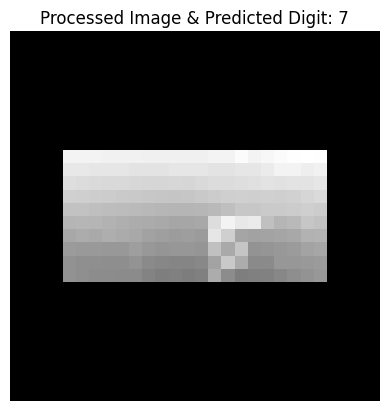


The model predicts that the digit is: 7
Confidence: 99.97%


In [ ]:
# Function to capture image from webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Image';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            document.body.removeChild(div);
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def preprocess_image(image_path):
    """Process the captured image for digit recognition"""
    try:
        # Load original image
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError("Could not load the captured image.")

        # Convert to grayscale
        gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

        # Invert the image (so digit is white, background is black)
        inverted_image = cv2.bitwise_not(gray_image)

        # Apply a binary threshold to get a clean black-and-white image
        _, thresholded = cv2.threshold(inverted_image, 100, 255, cv2.THRESH_BINARY)

        # Find the largest contour (the digit)
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Crop the image to the bounding box of the digit
            cropped_digit = inverted_image[y:y+h, x:x+w]

            # Resize the cropped digit to 20x20 while maintaining aspect ratio
            height, width = cropped_digit.shape
            if height > width:
                scale = 20 / height
                new_w = int(width * scale)
                resized_digit = cv2.resize(cropped_digit, (new_w, 20), interpolation=cv2.INTER_AREA)
            else:
                scale = 20 / width
                new_h = int(height * scale)
                resized_digit = cv2.resize(cropped_digit, (20, new_h), interpolation=cv2.INTER_AREA)

            # Create a new 28x28 canvas and center the resized digit
            processed_image = np.zeros((28, 28), dtype=np.float32)
            pad_x = (28 - resized_digit.shape[1]) // 2
            pad_y = (28 - resized_digit.shape[0]) // 2
            processed_image[pad_y:pad_y+resized_digit.shape[0], pad_x:pad_x+resized_digit.shape[1]] = resized_digit

            # Normalize the pixel values
            processed_image = processed_image / 255.0

            return processed_image, True
        else:
            return None, False

    except Exception as e:
        print(f"Error during preprocessing: {e}")
        return None, False

def predict_digit(processed_image):
    """Make prediction on the processed image"""
    try:
        # Reshape for model input
        input_image = processed_image.reshape(1, 28, 28, 1)
        
        # Make prediction
        predictions = model.predict(input_image, verbose=0)
        predicted_digit = np.argmax(predictions)
        confidence = np.max(predictions) * 100
        
        return predicted_digit, confidence, predictions[0]
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None, None

# Main function to run digit recognition
def run_recognition():
    if model is None:
        print("Error: Model not loaded. Cannot run recognition.")
        return
    
    print("Please draw a digit on a white background and position it clearly in the camera frame.")
    
    # Capture image
    image_path = take_photo()
    print(f"Image captured: {image_path}")
    
    # Process image
    processed_image, success = preprocess_image(image_path)
    
    if not success:
        print("No digit detected. Please ensure a clear digit is visible in the frame.")
        return
    
    # Make prediction
    predicted_digit, confidence, all_predictions = predict_digit(processed_image)
    
    if predicted_digit is None:
        print("Prediction failed.")
        return
    
    # Display results
    plt.figure(figsize=(12, 4))
    
    # Show processed image
    plt.subplot(1, 3, 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title(f"Processed Image")
    plt.axis('off')
    
    # Show confidence for all digits
    plt.subplot(1, 3, 2)
    digits = list(range(10))
    confidences = all_predictions * 100
    bars = plt.bar(digits, confidences)
    bars[predicted_digit].set_color('green')
    plt.title('Confidence for Each Digit')
    plt.xlabel('Digit')
    plt.ylabel('Confidence (%)')
    
    # Show top 3 predictions
    top_3_indices = np.argsort(all_predictions)[-3:][::-1]
    top_3_digits = [str(i) for i in top_3_indices]
    top_3_confs = [all_predictions[i] * 100 for i in top_3_indices]
    
    plt.subplot(1, 3, 3)
    colors = ['green', 'orange', 'red']
    plt.bar(top_3_digits, top_3_confs, color=colors)
    plt.title('Top 3 Predictions')
    plt.xlabel('Digit')
    plt.ylabel('Confidence (%)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPredicted digit: {predicted_digit}")
    print(f"Confidence: {confidence:.2f}%")
    
    print(f"\nTop 3 predictions:")
    for i, idx in enumerate(top_3_indices):
        print(f"{i+1}. Digit {idx}: {all_predictions[idx]*100:.1f}%")

# Check if model is ready
if model is not None:
    print("System ready. Run the cell below to start digit recognition.")
else:
    print("Please fix the model loading issue before proceeding.")

In [ ]:
# Run digit recognition
run_recognition()
